# Experimental Cluster used to develop and test ClusterCAD NRPS Domain Reaction Operators

**by Xavier Tao using code by Tyler Backman**

This version of the NRPS functionality tester is only intended to facilitate development and verify that NRPS domain reaction operators work as intended. 
It does not directly interact with models.py and/or build any domains from scratch (via a pipeline). That will be implemented in a future notebook. 

Note: this notebook must be run inside of a working version of ClusterCAD

In [2]:
# Connect to ClusterCAD
import os, sys
sys.path.insert(0, '/clusterCAD')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "clusterCAD.settings")
import django
django.setup()
import pks.models

# import libraries
from pks.models import Domain
from rdkit import Chem as chem
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from django.db import models

In [3]:
def plotMol(mol):
    # function to plot a target chemical structure and compare to a template
    template = chem.MolFromMolFile('input_data/phenalamide b.sdf')
    
    mcs = rdFMCS.FindMCS([mol, template], matchChiralTag=False, matchValences=False)
    atoms = [atom.GetIdx() for atom in template.GetAtoms()]
    mcsSmarts = chem.MolFromSmarts(mcs.smartsString)
    highlightAtomList1 = template.GetSubstructMatch(mcsSmarts)
    highlightAtomList2 = mol.GetSubstructMatch(mcsSmarts)
    nonMCSatoms = list(filter(lambda x: x not in highlightAtomList1, atoms))
    nonMCSatoms.sort(reverse=True)
    rwmol = chem.RWMol(template)
    for atom in nonMCSatoms:
        rwmol.RemoveAtom(atom)
    templateMol = rwmol.GetMol()
    AllChem.GenerateDepictionMatching2DStructure(mol, templateMol, acceptFailure=False)
    return Draw.MolsToGridImage([mol], legends=[''], molsPerRow=1, useSVG=True, subImgSize=(600, 600))
    # return Draw.MolsToGridImage([mol], legends=[''], molsPerRow=1, highlightAtomLists=[highlightAtomList2], useSVG=True, subImgSize=(600, 600))

In [4]:
# Grab Phenalamide cluster

cluster = pks.models.Cluster.objects.get(mibigAccession='BGC0001394.1')
cluster

# On second thought, no NRPS domains currently exist within ClusterCAD so we need to make our own

<Cluster: Phenalamide gene cluster>

In [120]:
# NRPS domains, directly taken and modified from models.py

aminoAcids = {
    # L-amino acids - use format <R_group>C[C@H](N)C(=O)[S] for L stereochemistry
    
    # special
    'gly': chem.MolFromSmiles('NCC(=O)[S]'),
    'cys': chem.MolFromSmiles('SC[C@H](N)C(=O)[S]'),
    'pro': chem.MolFromSmiles('C1CC[C@H](N1)C(=O)[S]'),
    
    # polar uncharged
    'ser': chem.MolFromSmiles('OC[C@H](N)C(=O)[S]'),
    'thr': chem.MolFromSmiles('CC(O)[C@H](N)C(=O)[S]'),
    'asn': chem.MolFromSmiles('NC(=O)C[C@H](N)C(=O)[S]'),
    'gln': chem.MolFromSmiles('NC(=O)CC[C@H](N)C(=O)[S]'),
    
    # polar charged
    'arg': chem.MolFromSmiles('N=C(N)NCCC[C@H](N)C(=O)[S]'),
    'his': chem.MolFromSmiles('N1=CNC=C1C[C@H](N)C(=O)[S]'),
    'lys': chem.MolFromSmiles('NCCCC[C@H](N)C(=O)[S]'),
    'asp': chem.MolFromSmiles('OC(=O)C[C@H](N)C(=O)[S]'),
    'glu': chem.MolFromSmiles('OC(=O)CC[C@H](N)C(=O)[S]'),
    
    # nonpolar
    'ala': chem.MolFromSmiles('C[C@H](N)C(=O)[S]'),
    'val': chem.MolFromSmiles('CC(C)[C@H](N)C(=O)[S]'),
    'ile': chem.MolFromSmiles('CCC(C)[C@H](N)C(=O)[S]'),
    'leu': chem.MolFromSmiles('CC(C)C[C@H](N)C(=O)[S]'),
    'met': chem.MolFromSmiles('CSCC[C@H](N)C(=O)[S]'),
    'phe': chem.MolFromSmiles('C1=CC=CC=C1C[C@H](N)C(=O)[S]'),
    'tyr': chem.MolFromSmiles('C1=CC(O)=CC=C1C[C@H](N)C(=O)[S]'),
    'trp': chem.MolFromSmiles('C2=CC=CC1=C2C(=CN1)C[C@H](N)C(=O)[S]'), 
    
    # amino acid derivatives
    'pip': chem.MolFromSmiles('C1CC[N]C(C1)C(=O)[S]'),
}

class A():
    # Adenylation domain: picks substrate and catalyzes its addition to PCP

    SUBSTRATE_CHOICES = tuple(((k, k) for k in list(set(list(aminoAcids.keys())))))

    substrate = ''
    '''
    substrate = models.CharField(
        max_length=20,
        choices=SUBSTRATE_CHOICES,
        default='gly', # simplest amino acid
        blank=False,
    )
    '''
    def operation(self, chain):
        
        if not chain:
            return aminoAcids[self.substrate] # no chain = pass on the substrate
        else:
            rxn = AllChem.ReactionFromSmarts(('[C:2](=[O:3])[S:1].' # incoming chain
                                              '[N:6][C:7][C:8](=[O:9])[S:10]>>' # substrate
                                              '[C:2](=[O:3])[N:6][C:7][C:8](=[O:9])[S:10]' # product
                                              '.[S:1]')) # remaining thiol
            
            # ensure there is only one thiol ester (reaction site) in the chain
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('CC(=O)S'),
                       useChirality=True)) == 1, chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain, aminoAcids[self.substrate]))[0][0]
            chem.SanitizeMol(prod)
            return prod

    def __str__(self):
        return 'substrate %s' % (self.substrate)

    def __repr__(self):
        return ("A")


class Cy():
    # (Hetero)Cyclization domain: picks substrate and cyclizes it, forming thiazoline or oxazoline
    # Currently can only cyclize using cysteine and serine/threonine and requires a chain

    SUBSTRATE_CHOICES = tuple(((k, k) for k in list(set(list(aminoAcids.keys())))))

    '''substrate = ''
    
    substrate = models.CharField(
        max_length=20,
        choices=SUBSTRATE_CHOICES,
        default='gly', # simplest amino acid
        blank=False,
    )
    '''
    def operation(self, chain):
        
        # ensures that a chain preceeds cyclization domain
        assert chain
        
        # first step - condensation
        rxn1 = AllChem.ReactionFromSmarts(('[C:2](=[O:3])[S:1]' # incoming chain
                                          '.[N:6][C:7][C:8](=[O:9])[S:10]>>' # substrate
                                          '[C:2](=[O:3])[N:6][C:7][C:8](=[O:9])[S:10]' # product
                                          '.[S:1]')) # remaining thiol

        # ensure there is only one thiol ester reaction site
        assert len(chain.GetSubstructMatches(chem.MolFromSmiles('CC(=O)S'),
                   useChirality=True)) == 1, chem.MolToSmiles(chain)
        intermediate = rxn1.RunReactants((chain, aminoAcids[self.substrate]))[0][0]
        chem.SanitizeMol(intermediate)
        
        print(chem.MolToSmiles(intermediate))
        print("smiles - oxa precursor")
        print(len(intermediate.GetSubstructMatches(chem.MolFromSmiles('CC(=O)NC(CO)C(=O)[S]'), useChirality=True)))
        print("smarts - oxa precursor (aliphatic c)")
        print(len(intermediate.GetSubstructMatches(chem.MolFromSmarts('[C:11]C(=[O:3])[N:6][C:7]([C:5]O)[C:8](=[O:9])[S:10]'), useChirality=True)))
        print("smarts - oxa precursor (aromatic c)")
        print(len(intermediate.GetSubstructMatches(chem.MolFromSmarts('[c:11]C(=[O:3])[N:6][C:7]([C:5]O)[C:8](=[O:9])[S:10]'), useChirality=True)))
        print("smarts - oxa precursor (any c)")
        print(len(intermediate.GetSubstructMatches(chem.MolFromSmarts('[C,c:11]C(=[O:3])[N:6][C:7]([C:5]O)[C:8](=[O:9])[S:10]'), useChirality=True)))
        
        # Cysteine -> Thiazoline case | second step - intramolecular cyclization
        if self.substrate == 'cys':
            rxn2 = AllChem.ReactionFromSmarts(('[C,c:11]C(=[O:3])[N:6][C:7]([C:5]S)[C:8](=[O:9])[S:10]>>' # condensation product backbone with thiol nucleophile
                                               '[C,c:11]C1=[N:6][C:7]([C:5]S1)[C:8](=[O:9])[S:10]' # thiazoline
                                               '.[O:3]')) # water from dehydration

            # make sure there is only one thiol ester-linked cyclization backbone
            assert len(intermediate.GetSubstructMatches(chem.MolFromSmiles('C(=O)NC(CS)C(=O)S'),
                   useChirality=True)) == 1, chem.MolToSmiles(intermediate)
            prod = rxn2.RunReactants((intermediate,))[0][0] # intramolecular rxn
            chem.SanitizeMol(prod)
            return prod

        # Threonine/Serine -> Oxazoline case | second step - intramolecular cyclization
        elif (self.substrate == 'thr' or self.substrate == 'ser'):
            rxn2 = AllChem.ReactionFromSmarts(('[C,c:11]C(=[O:3])[N:6][C:7]([C:5]O)[C:8](=[O:9])[S:10]>>' # condensation product backbone with alcohol nucleophile
                                               '[C,c:11]C1=[N:6][C:7]([C:5]O1)[C:8](=[O:9])[S:10]' # oxazoline
                                               '.[O:3]')) # water from dehydration

            # make sure there is only one thiol ester-linked cyclization backbone
            assert len(intermediate.GetSubstructMatches(chem.MolFromSmiles('C(=O)NC(CO)C(=O)S'),
                   useChirality=True)) == 1, chem.MolToSmiles(intermediate)
            prod = rxn2.RunReactants((intermediate,))[0][0] # intramolecular rxn
            chem.SanitizeMol(prod)
            return prod

        # Cyclization for everything else not supported and raises exception
        else: 
            raise Exception("Cyclization of this substrate is currently unsupported. ")

    def __str__(self):
        return 'substrate %s' % (self.substrate)

    def __repr__(self):
        return ("Cy")

class Ox():
    # Oxidation domain: Oxidizes thiazolines and oxazolines into thiazoles and oxazoles
    # the operation function assumes Ox immediately follows Cy domain

    #active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):
        
        if self.active == True:
            # make sure "zoline"-thioester moiety is present
            assert len(chain.GetSubstructMatches(chem.MolFromSmarts('C1=NC(C*1)C(=O)S'), useChirality=True)) == 1
            
            # checks if moiety to oxidize is thiazoline - if so, oxidizes to thiazol
            if len(chain.GetSubstructMatches(chem.MolFromSmiles('C1=NC(CS1)C(=O)S'), useChirality=True)) == 1:
                rxn = AllChem.ReactionFromSmarts(('[C,c:11]C1=[N:6][CH1:7]([C:5][*:12]1)[C:8](=[O:9])[S:10]>>'
                                                  '[C,c:11]C1=[N:6][CH0:7](=[C:5][*:12]1)[C:8](=[O:9])[S:10]'))

            # checks if moiety to oxidize is oxazoline - if so, oxidizes to oxazole
            elif len(chain.GetSubstructMatches(chem.MolFromSmiles('C1=NC(CO1)C(=O)S'), useChirality=True)) == 1:
                rxn = AllChem.ReactionFromSmarts(('[C,c:11]C1=[N:6][CH1:7]([C:5]O1)[C:8](=[O:9])[S:10]>>'
                                                  '[C,c:11]C1=[N:6][CH0:7](=[C:5]O1)[C:8](=[O:9])[S:10]'))
            else:
                raise Exception("This is a 'zoline' moiety currently unsupported. ")
            
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        
        else:
            return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("Ox")

class Red():
    # Reduction domain: Reduces thiazolines and oxazolines into thiazolidines and oxazolidines
    # the operation function assumes Red immediately follows Cy domain
    # **NOT TO BE CONFUSED WITH R-domain (reductase to terminal aldehyde/alcohol)

    #active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):

        if self.active == True:
            # make sure "zoline"-thioester moiety is present
            assert len(chain.GetSubstructMatches(chem.MolFromSmarts('C1=NC(C*1)C(=O)S'), useChirality=True)) == 1
            
            # checks if moiety to reduce is thiazoline - if so, reduces to thiazolidine
            if len(chain.GetSubstructMatches(chem.MolFromSmiles('C1=NC(CS1)C(=O)S'), useChirality=True)) == 1:
                rxn = AllChem.ReactionFromSmarts(('[C,c:11]C1=[N:6][CH1:7]([C:5]S1)[C:8](=[O:9])[S:10]>>'
                                                  '[C,c:11]C1[N:6][CH0:7]([C:5]S1)[C:8](=[O:9])[S:10]'))

            # checks if moiety to reduce is oxazoline - if so, oxidizes to oxazolidine
            elif len(chain.GetSubstructMatches(chem.MolFromSmiles('C1=NC(CO1)C(=O)S'), useChirality=True)) == 1:
                rxn = AllChem.ReactionFromSmarts(('[C,c:11]C1=[N:6][CH1:7]([C:5]O1)[C:8](=[O:9])[S:10]>>'
                                                  '[C,c:11]C1[N:6][CH0:7]([C:5]O1)[C:8](=[O:9])[S:10]'))
            else:
                raise Exception("This is a 'zoline' moiety currently unsupported. ")
            
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        
        else:
            return chain

    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("Red")

class E():
    # Epimerization domain: Epimerizes L-amino acids to D-amino acids
    
    # active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):
        # Does not work on thiazoline/oxazol type cyclic amino acids -- don't know if we'll see those cases
        
        # ensures if moiety to epimerize is a non-cyclized L-amino acid - if so, epimerizes to D-amino acid
        # Gly would throw error, smallest amino acid recognized is L-Ala
        if self.active == True:
            rxn = AllChem.ReactionFromSmarts(('[C:5][C@H:7]([N:6])[C:8](=[O:9])[S:10]>>'
                                              '[C:5][C@@H:7]([N:6])[C:8](=[O:9])[S:10]'))
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('C[C@H](N)C(=O)[S]'),
                   useChirality=True)) == 1, chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        else:
            return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("E")

class nMT():
    # N-methylation domain: methylates amine
    
    #active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):

        if self.active == True:
            rxn = AllChem.ReactionFromSmarts(('[N:6][C:7][C:8](=[O:9])[S:10]>>'
                                              '[N:6](C)[C:7][C:8](=[O:9])[S:10]'))
            
            # make sure there is only one nitrogen reaction site
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('NCC(=O)S'),
                       useChirality=True)) == 1, chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        else:
            return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("nMT")

class F():
    # Formylation domain: formylates amine
    
    #active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):

        if self.active == True:
            rxn = AllChem.ReactionFromSmarts(('[N:6][C:7][C:8](=[O:9])[S:10]>>'
                                              '[N:6](C(=O))[C:7][C:8](=[O:9])[S:10]'))
            
            # make sure there is only one nitrogen reaction site
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('NCC(=O)S'),
                       useChirality=True)) == 1, chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        else:
            return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("F")
    
class MOX():
    # Monooxygenase domain: alternative chain release forming amide (myxothiazol, melithiazol)
    # actual mechanism: adds glycine, hydroxylates alpha-carbon, then tautomerizes
    # TE releases subsequent glyoxylate from terminal PCP
    # NOT TO BE CONFUSED WITH P450-series MONOOXYGENASES
    
    #active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):

        if self.active == True:
            # forms amide from thioester (ignores actual mechanism)
            rxn = AllChem.ReactionFromSmarts(('[N:6][C:7][C:8](=[O:9])[S:10]>>'
                                              '[N:6][C:7][C:8](=[O:9])N.[S:10]'))
            
            # make sure there is only one nitrogen reaction site
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('CC(=O)S'),
                       useChirality=True)) == 1, chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        else:
            return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("MOX")
    
class R():
    # Reductase domain: alternative chain release forming alcohol or aldehyde
    
    #active = models.BooleanField(default=True)
    active = True
    
    TYPE_CHOICES = ('COH','CHO')
    
    type = models.CharField(
        max_length=3,
        choices=TYPE_CHOICES,
        default=None,
        blank=False,
    )
    
    def operation(self, chain):

        if self.active == True:
            # Transformation determined by type
            if self.type == 'COH':
                # forms alcohol from thioester
                rxn = AllChem.ReactionFromSmarts(('[N:6][C:7][C:8](=[O:9])[S:10]>>'
                                                  '[N:6][C:7][C:8][O:9].[S:10]'))
            elif self.type == 'CHO':
                # forms aldehyde from thioester
                rxn = AllChem.ReactionFromSmarts(('[N:6][C:7][C:8](=[O:9])[S:10]>>'
                                                  '[N:6][C:7][C:8](=[O:9]).[S:10]'))
            
            # make sure there is only one thioester reaction site
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('CC(=O)S'),
                       useChirality=True)) == 1, chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        else:
            return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("R")
    
class X():
    # P450 recruiter with ungeneralizable catalytic activity
    # activity depends on recruited P450
    
    #active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):
        return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("X")

In [121]:
# print SMILES for the current Phenalamide product
molProduct = cluster.computeProduct(computeMCS=False, recompute=True)[-1]
smilesProduct = chem.MolToSmiles(molProduct, isomericSmiles=True)
print(smilesProduct)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)[S]


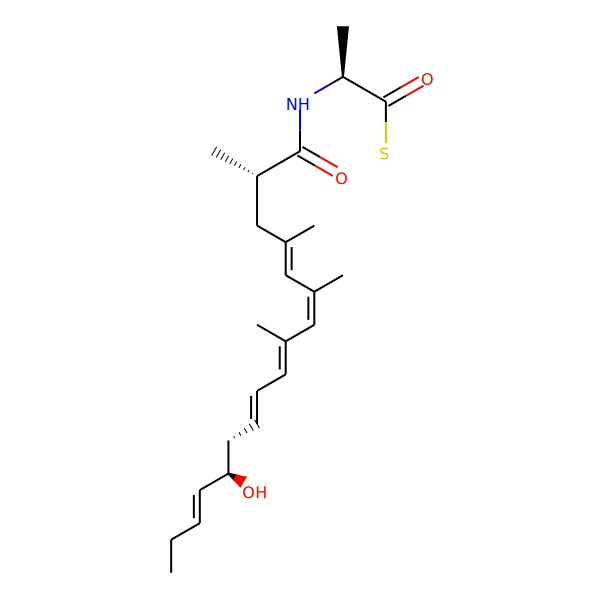

In [122]:
# test A domain using phenalamide backbone

A_domain = A()
A_domain.substrate = 'ala'

prod1 = A_domain.operation(chain=molProduct)
plotMol(prod1)

# pretty close but not quite there because of the N-ACP

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CS)C(=O)[S]
smiles - oxa precursor
0
smarts - oxa precursor (aliphatic c)
0
smarts - oxa precursor (aromatic c)
0
smarts - oxa precursor (any c)
0


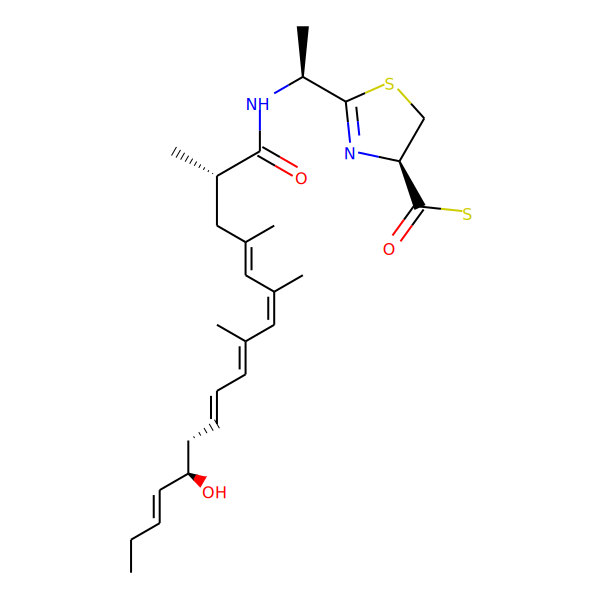

In [123]:
# test Cy domain (thiazoline) using phenalamide backbone

Cy_domain_cys = Cy()
Cy_domain_cys.substrate = 'cys'

prod2 = Cy_domain_cys.operation(chain=prod1)
plotMol(prod2)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C(=O)N[C@H](C(=O)[S])C(C)O
smiles - oxa precursor
1
smarts - oxa precursor (aliphatic c)
1
smarts - oxa precursor (aromatic c)
0
smarts - oxa precursor (any c)
1


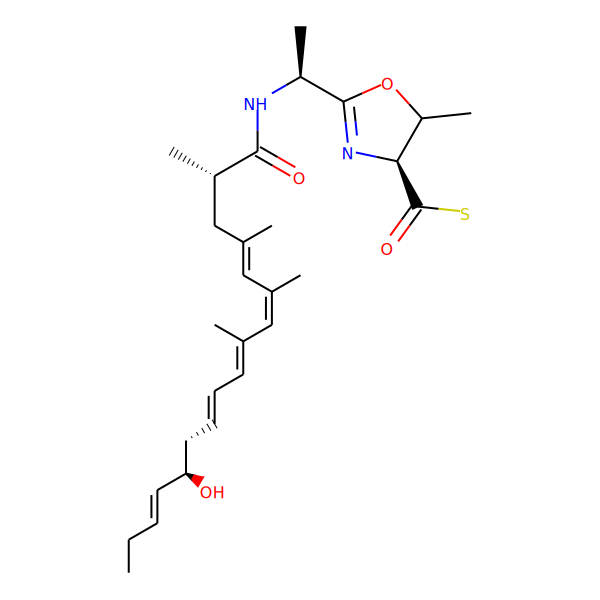

In [124]:
# test Cy domain (oxazoline) using phenalamide backbone

Cy_domain_thr = Cy()
Cy_domain_thr.substrate = 'thr' # alternatively use ser

prod3 = Cy_domain_thr.operation(chain=prod1)
plotMol(prod3)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](C(=O)N[C@@H](CS)C(=O)[S])C(C)O1
smiles - oxa precursor
0
smarts - oxa precursor (aliphatic c)
0
smarts - oxa precursor (aromatic c)
0
smarts - oxa precursor (any c)
0
CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(C(=O)N[C@H](C(=O)[S])C(C)O)cs2)C(C)O1
smiles - oxa precursor
1
smarts - oxa precursor (aliphatic c)
0
smarts - oxa precursor (aromatic c)
1
smarts - oxa precursor (any c)
1


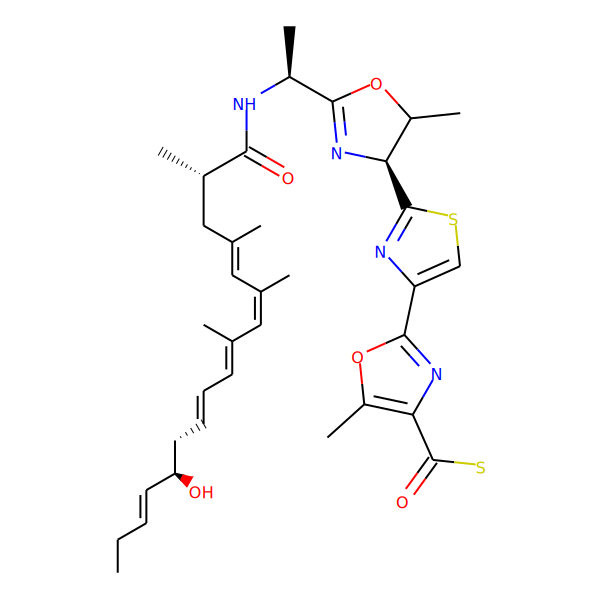

In [125]:
# test Ox domain with every case possible using phenalamide backbone

Ox_domain = Ox()

# Cy then Ox for both thiazoline and oxazoline cases
# should add one thiazol and one oxazole to previous chain
prod4 = Cy_domain_cys.operation(chain=prod3)
#print(chem.MolToSmiles(prod4))

prod5 = Ox_domain.operation(chain=prod4)
#print(chem.MolToSmiles(prod5))

#works until here, Cy refuses to cyclize after oxa/thiazoles!!!

prod6 = Cy_domain_thr.operation(chain=prod5) # <--- error occurs if chain=prod5 (has thiazol) instead
#print("prod6")
#print(chem.MolToSmiles(prod6))

prod7 = Ox_domain.operation(chain=prod6)
#print(chem.MolToSmiles(prod7))

plotMol(prod7)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N[C@@H](Cc4c[nH]c5ccccc45)C(=O)[S])c(C)o3)cs2)C(C)O1


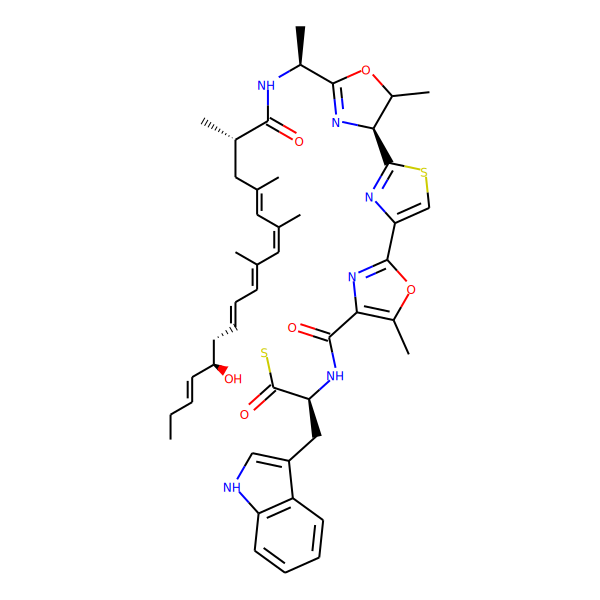

In [107]:
# setup E domain test by adding L-Trp

A_domain2 = A()
A_domain2.substrate = 'trp'

prod8 = A_domain2.operation(chain=prod7)
print(chem.MolToSmiles(prod8))
plotMol(prod8)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N[C@H](Cc4c[nH]c5ccccc45)C(=O)[S])c(C)o3)cs2)C(C)O1


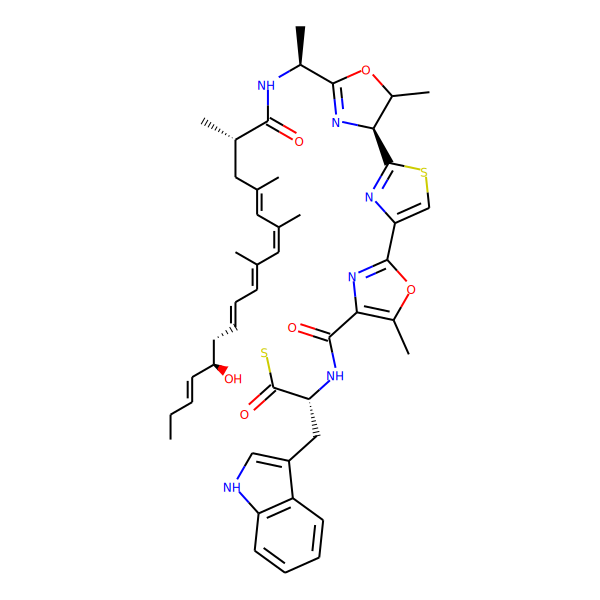

In [108]:
# test E domain by epimerizing L-Trp to D-Trp

E_domain = E()

prod9 = E_domain.operation(chain=prod8)
print(chem.MolToSmiles(prod9))
plotMol(prod9)


# test to see if it can turn D to L (PASSED: assertion error raised)
#prod10 = E_domain.operation(chain=prod9)
#chem.SanitizeMol(prod10)
#print(chem.MolToSmiles(prod10))

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N(C)[C@H](Cc4c[nH]c5ccccc45)C(=O)[S])c(C)o3)cs2)C(C)O1


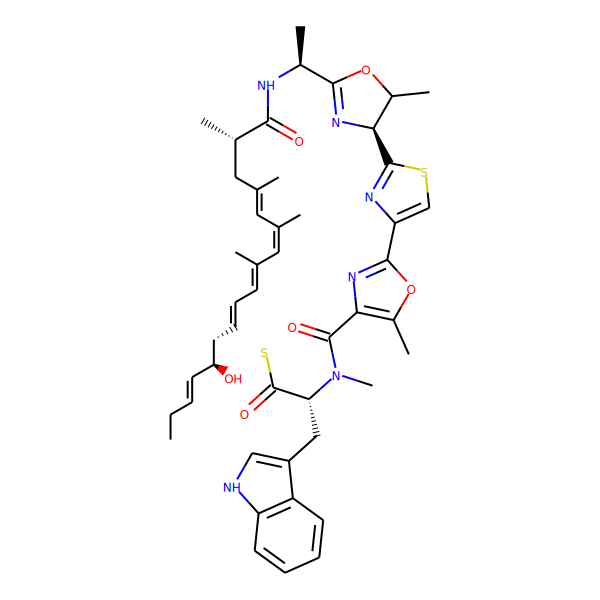

In [109]:
# test nMT domain by N-methylating the most recently added amino acid

nMT_domain = nMT()

prod11 = nMT_domain.operation(chain=prod9)
print(chem.MolToSmiles(prod11))
plotMol(prod11)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N(C)[C@H](Cc4c[nH]c5ccccc45)C(=O)N[C@@H](CS)C(=O)[S])c(C)o3)cs2)C(C)O1
smiles - oxa precursor
0
smarts - oxa precursor (aliphatic c)
0
smarts - oxa precursor (aromatic c)
0
smarts - oxa precursor (any c)
0
CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N(C)[C@H](Cc4c[nH]c5ccccc45)C4=N[C@H](C(=O)[S])CS4)c(C)o3)cs2)C(C)O1
CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N(C)[C@H](Cc4c[nH]c5ccccc45)C4N[C](C(=O)[S])CS4)c(C)o3)cs2)C(C)O1
CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N(C)[C@H](Cc4c[nH]c5ccccc45)C4N[C](C(=O)N[C@H](C(=O)[S])C(C)O)CS4)c(C)o3)cs2)C(C)O1
smiles - oxa precursor
1
smarts - oxa precursor (aliphatic c)
1
smarts - oxa precursor (aromatic c)
0
smarts - oxa precursor (any c)
1
CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C

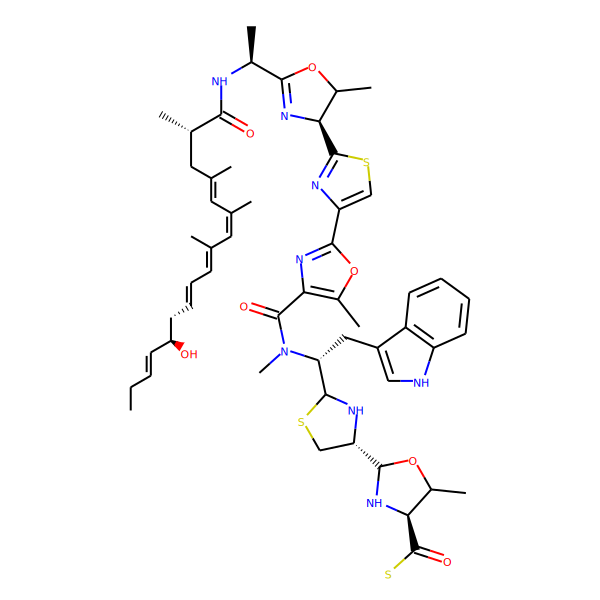

In [110]:
# test Red domain by adding and reducing a thiazoline and then adding and reducing an oxazoline

Red_domain = Red()

prod12 = Cy_domain_cys.operation(chain=prod11)
print(chem.MolToSmiles(prod12))

prod13 = Red_domain.operation(chain=prod12)
print(chem.MolToSmiles(prod13))

prod14 = Cy_domain_thr.operation(chain=prod13)
print(chem.MolToSmiles(prod14))

prod15 = Red_domain.operation(chain=prod14)
print(chem.MolToSmiles(prod15))
plotMol(prod15)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N(C)[C@H](Cc4c[nH]c5ccccc45)C4N[C](C5N[C](C(N)=O)C(C)O5)CS4)c(C)o3)cs2)C(C)O1


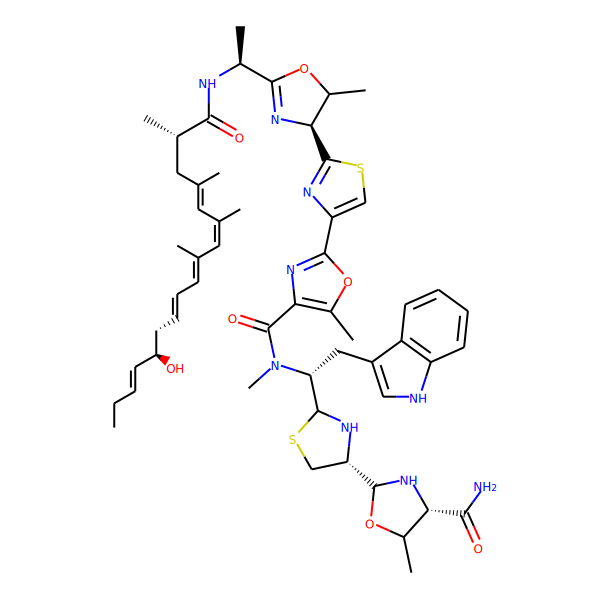

In [111]:
# test MOX domain chain termination

MOX_domain = MOX()

prod16 = MOX_domain.operation(chain=prod15)
print(chem.MolToSmiles(prod16))
plotMol(prod16)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N(C)[C@H](Cc4c[nH]c5ccccc45)C4N[C](C5N[C](C=O)C(C)O5)CS4)c(C)o3)cs2)C(C)O1


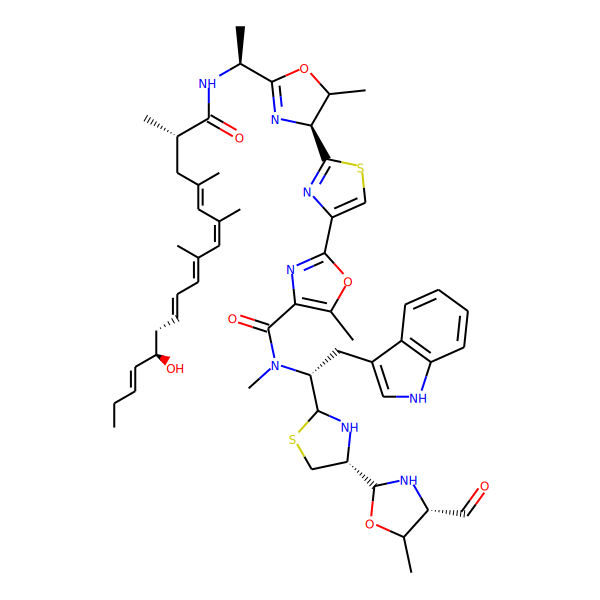

In [112]:
# test R domain chain termination

R_domain = R()
R_domain.type = 'CHO' # alternatively use 'COH'

prod17 = R_domain.operation(chain=prod15)
print(chem.MolToSmiles(prod17))
plotMol(prod17)

CCC=[C][C@H](O)CC=[C]C=C(C)C=C(C)C=C(C)[CH][C@H](C)C(=O)N[C@@H](C)C1=N[C@H](c2nc(-c3nc(C(=O)N(C)[C@H](Cc4c[nH]c5ccccc45)C4N[C](C5OC(C)[C](C(=O)[S])N5C=O)CS4)c(C)o3)cs2)C(C)O1


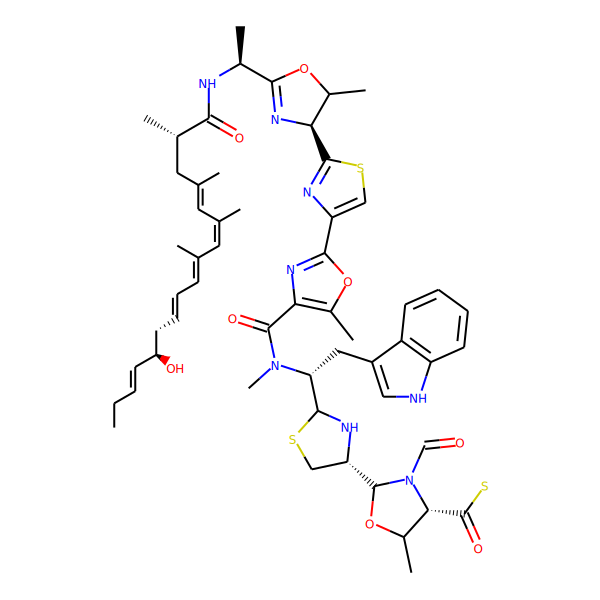

In [113]:
# test F domain (in a non-loading context)

F_domain = F()
prod18 = F_domain.operation(chain=prod15)
print(chem.MolToSmiles(prod18))
plotMol(prod18)